In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt, ExponentialSmoothing


from acquire import wrangle_store_data
from prepare import index_time_data, prep_store_data

In [2]:
df = wrangle_store_data()

In [3]:
df['sale_total'] = df.sale_amount * df.item_price

In [4]:
df = prep_store_data(df)

In [5]:
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,quantity,store_address,store_zipcode,store_city,store_state,sale_total,month,dow,sales_total
sale_date,,,,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,10.92,01-Jan,2-Tue,10.92
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,30.16,01-Jan,2-Tue,30.16
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,308.48,01-Jan,2-Tue,308.48
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,197.55,01-Jan,2-Tue,197.55
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,25.16,01-Jan,2-Tue,25.16


In [6]:
df_resampled = df.resample('d')[['quantity','sales_total']].sum()
df_resampled.head()

,quantity,sales_total
sale_date,,
2013-01-01,13696,73844.01
2013-01-02,13678,73570.58
2013-01-03,14488,78169.48
2013-01-04,15677,84467.73
2013-01-05,16237,87621.85


In [7]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

365

In [8]:
# validate will go from 913 to 913+548
validate_end_index = train_size + validate_size
validate_end_index

1461

In [9]:
# train will go from 0 to 912
train = df_resampled[:train_size]

In [10]:
# validate will go from 912 to 1458
validate = df_resampled[train_size:validate_end_index]

In [11]:
# test will include 1459 to the end
test = df_resampled[validate_end_index:]

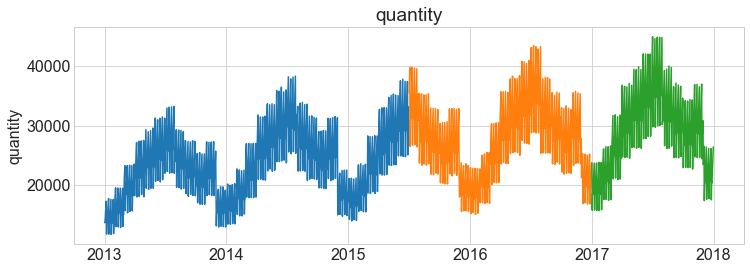

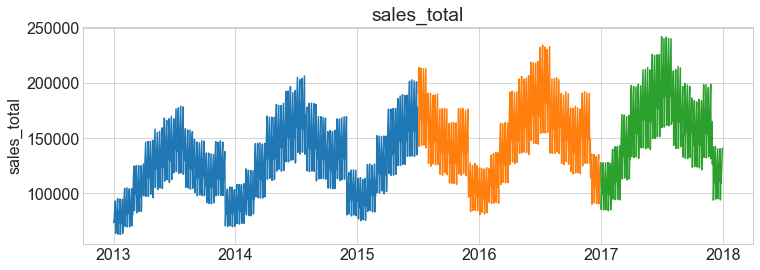

In [12]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [13]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [14]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [15]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [16]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [17]:
train['sales_total'][-1:][0]

178036.63999999998

# last value

In [18]:
# take the last item of sales total and assign to variable
last_sales = train['sales_total'][-1:][0]
last_sales

178036.63999999998

In [19]:
# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]
last_quantity

33134

In [20]:
yhat_df = pd.DataFrame(
    {'sales_total': [last_sales],
     'quantity': [last_quantity]},
    index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03,178036.64,33134
2015-07-04,178036.64,33134
2015-07-05,178036.64,33134
2015-07-06,178036.64,33134
2015-07-07,178036.64,33134


sales_total -- RMSE: 42805


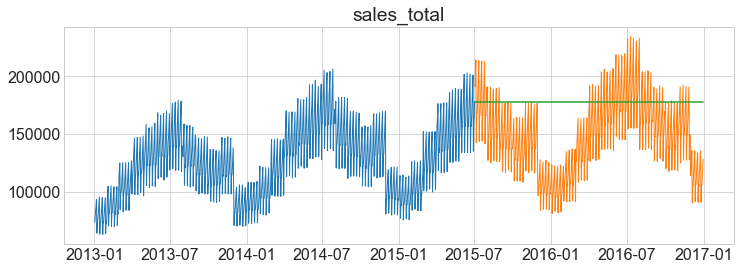

In [21]:
plot_and_eval('sales_total')

quantity -- RMSE: 7973


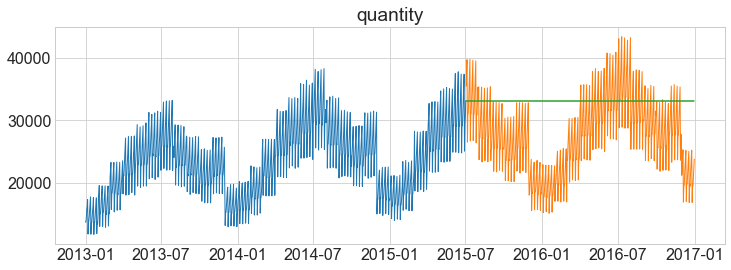

sales_total -- RMSE: 42805


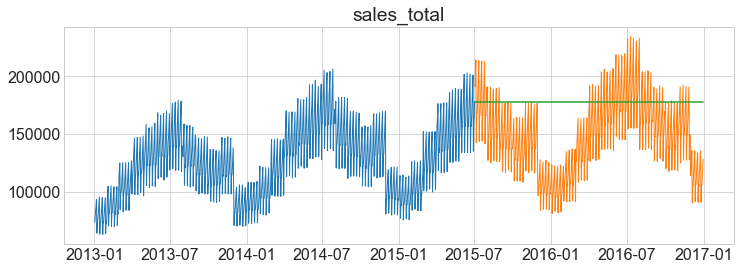

In [22]:
for col in train.columns:
    plot_and_eval(col)

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0


# simple average

In [24]:
# compute simple average
avg_sales = round(train['sales_total'].mean(), 2)
avg_sales

127573.19

In [25]:
avg_quantity = round(train['quantity'].mean(), 2)
avg_quantity

23728.25

In [26]:
def make_predictions(sales=None, quantity=None):
    yhat_df = pd.DataFrame({'sales_total': [sales],
                           'quantity': [quantity]},
                          index=validate.index)
    return yhat_df

In [27]:
yhat_df = make_predictions(avg_sales, avg_quantity)

quantity -- RMSE: 7360


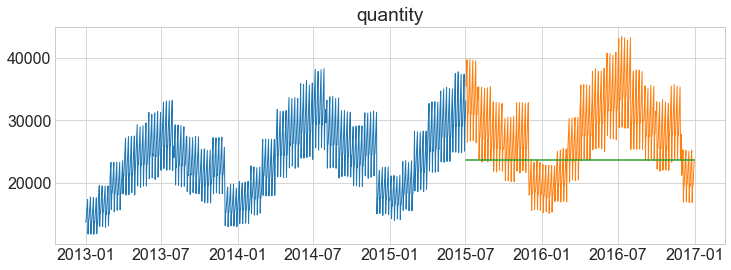

sales_total -- RMSE: 39568


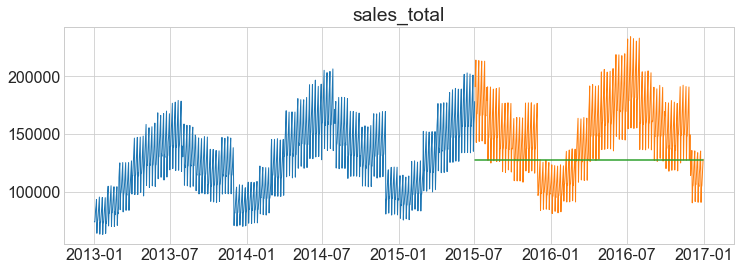

In [28]:
for col in train.columns:
    plot_and_eval(col)

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0
2,simple_average,quantity,7360.0
3,simple_average,sales_total,39568.0


# moving average/

In [30]:
period=30
train['sales_total'].rolling(period).mean()[-1]

169649.37633333335